In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# setting theme for plots
params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=params)

### Importing data and preprocessing

Here the dataset is formed by first combining the main submissions and main comments. The preprocessing steps are:
- the author and subreddit columns are kept
- the deleted and AutoModerator posts are removed
- 1,000,000 rows are kept for the analysis

In [3]:
main1 = pd.read_csv("data/main_submissions.csv", usecols=["author", "subreddit"], dtype={"author": str, "subreddit": str}, nrows=100000)
main2 = pd.read_csv("data/main_comments.csv", usecols=["author", "subreddit"], dtype={"author": str, "subreddit": str}, nrows=900000)
dataset = pd.concat([main1, main2])
dataset = dataset[(dataset["author"] != "Io99IHkg-4QzX6xbKwbte0cuzp4=") & (dataset["author"] != "EA1r-K5p_lVBLesLhCFRrKOPN-I=")]
dataset.head(10)

,author,subreddit
0,ZkakZ8xfXNiL6wUXhJhRU3Ysa7c=,AskReddit
1,pQ8j9hcuty1RBfCkUutL0cy9Zco=,pics
2,GH3YzjQCtBT4DkTjcxWb2-vPoa0=,Market76
3,57zAuZ7GS2EvQeCSXqU19wYZgjs=,funny
4,HY8UtHbd9PNUDFmaAkm4-10hgmA=,PrequelMemes
5,9tH33QdJxwKi2qmwYsbGaaEY18s=,politics
6,9tH33QdJxwKi2qmwYsbGaaEY18s=,AskReddit
7,MxOiFAejBYCW5pyC1OqtxxQ6OF0=,AskReddit
8,UYhe6ih-1ivvv0VGI8c2yOnF8M4=,teenagers
9,AtJhCRzBKaitBvgRO9h1ylOdSgc=,FreeKarma4U


### Incorporating community embedding

Here the metadata and vectors data are imported and preprocessed.

In [4]:
metadata = pd.read_csv("data/embedding-metadata.tsv", sep="\t")
vectors = pd.read_csv("data/embedding-vectors.tsv", sep="\t")
metadata = metadata.head(10005)
vectors = vectors[(metadata["over18"] == False)]
metadata = metadata[(metadata["over18"] == False)]
metadata = metadata.reset_index(drop=True)
vectors = vectors.reset_index(drop=True)

A function to obtain a vector from a subreddit is created, which will be used in later steps.

In [5]:
metadata_communities = set(metadata["community"])

community_vectors = dict()
for i in range(metadata.shape[0]):
    community_vectors[metadata["community"][i]] = vectors.iloc[i]

# note: sr stands for subreddit
def srs_to_vectors(text):
    return [community_vectors[w] for w in text if w in metadata_communities]

We further preprocess the dataset by removing rows with subreddits that are not in the metadata communities.

In [6]:
dataset = dataset[dataset["subreddit"].isin(metadata_communities)]

### Calculating GS scores for each user

The center of mass for each user and then the GS score for each user are calculated.

In [7]:
# note: pp stands for preprocessed
author_srs = dataset.groupby("author")["subreddit"].apply(' '.join).reset_index(name="subreddit")
author_srs_pp = dataset.groupby("author")["subreddit"].apply(list).reset_index(name="subreddit")["subreddit"]

# calculating center of mass values
u_i = [sum(srs_to_vectors(i)) for i in author_srs_pp]

# calculating GS score values
gs_i = []
for (i, row) in enumerate(author_srs_pp):
    vectors_in_row = srs_to_vectors(row)
    cm_norm = np.linalg.norm(u_i[i])
    len_vectors = len(vectors_in_row)
    if (len_vectors != 0):
        gs_i.append(sum(map(lambda x: (np.dot(x, u_i[i]))/cm_norm, vectors_in_row))/len_vectors)
    else:
        gs_i.append(0)

author_srs = author_srs.assign(cm = u_i)
author_srs = author_srs.assign(gs_score = gs_i)

# transforming values to match the definition of GS score
scaler = MinMaxScaler(feature_range=(-1, 1))
author_srs["gs_score"] = list(map(lambda x: -x[0], scaler.fit_transform(author_srs[["gs_score"]])))

author_srs["gs_score"].head(10)

0    0.394633
1   -0.006927
2    0.007609
3    0.926359
4    0.590701
5    0.817689
6    0.082136
7    0.298076
8    0.016294
9    0.251438
Name: gs_score, dtype: float64

### Calculating GS scores for each subreddit

The GS scores are for each subreddit are calculated using the GS scores for each user in the subreddit.

In [8]:
author_gs_dict = pd.Series(author_srs["gs_score"].values, index=author_srs["author"]).to_dict()
sr_authors = dataset.groupby("subreddit")["author"].apply(list).reset_index(name="authors")

gs_j = []
for (i, row) in enumerate(sr_authors["authors"]):
  gs_j.append(np.mean(list(map(lambda x: author_gs_dict[x], row))))

sr_authors = sr_authors.assign(gs_score = gs_j)
sr_gs_dict = pd.Series(sr_authors["gs_score"].values, index=sr_authors["subreddit"]).to_dict()

sr_authors["gs_score"].head(10)

0    0.281720
1    0.801444
2    0.141649
3    0.051851
4    0.096121
5    0.296728
6    0.275662
7    0.897412
8    0.406748
9    0.307020
Name: gs_score, dtype: float64

### GS score distribution for topics related to "news"

The gs_dist function takes a subreddit as input and returns the most similar subreddits with their corresponding GS scores (sorted by GS score). We test it with the news subreddit.

In [9]:
communities_used = set(dataset["subreddit"].drop_duplicates())

def gs_dist(x):
    similar = [(i, np.dot(community_vectors[x], community_vectors[i])/ \
            (np.linalg.norm(community_vectors[x])*np.linalg.norm(community_vectors[i]))) for i in communities_used]
    similar = sorted(similar, key=lambda x: x[1], reverse=True)[1:11]
    return pd.DataFrame(sorted([(i[0], sr_gs_dict[i[0]]) for i in similar], key=lambda x: x[1], reverse=True), columns=["subreddit", "gs_score"])

gs_dist("news")

,subreddit,gs_score
0,DestinyTheGame,0.479266
1,videos,0.448635
2,canada,0.391248
3,anime,0.377637
4,gaming,0.362472
5,relationship_advice,0.353357
6,movies,0.331859
7,SquaredCircle,0.252884
8,pcmasterrace,0.232065
9,classicwow,-0.166163


Here, we plot the GS score distribution for the similar topics.

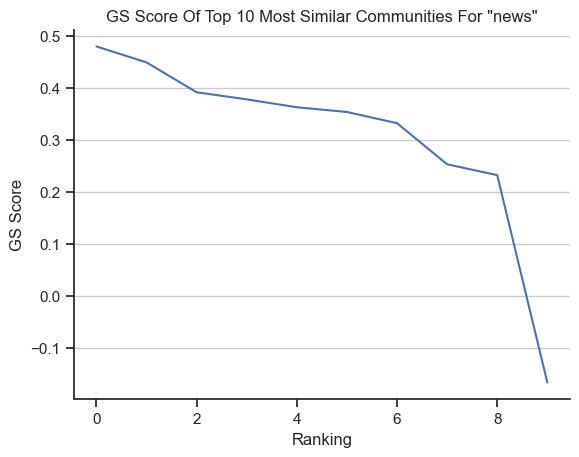

In [10]:
gs_dist("news")["gs_score"].plot(title="GS Score Of Top 10 Most Similar Communities For \"news\"", xlabel="Ranking", ylabel="GS Score").yaxis.grid(True)

The graph appears to be linear from 0 to 8, and then a spike occurs afterwards.

### Generalizing to determine trend

We can plot a line for each community based on gs_dist and analyze the graph to determine if there is a trend.

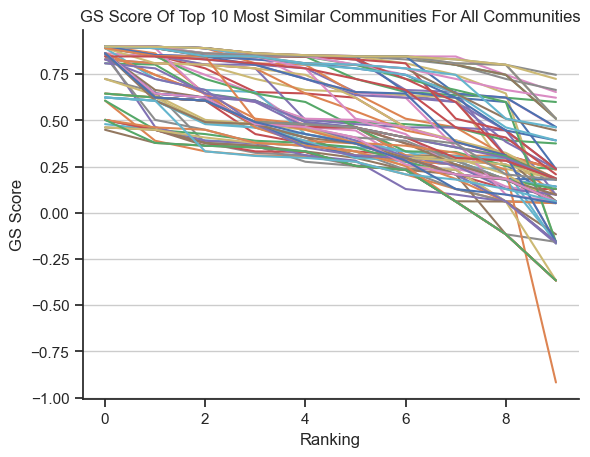

In [11]:
for i in communities_used:
    gs_dist(i)["gs_score"].plot(title="GS Score Of Top 10 Most Similar Communities For All Communities", xlabel="Ranking", ylabel="GS Score").yaxis.grid(True)

Based on the graph, the trend appears to be linear in most cases, and in some cases there is a spike near the end.

As an extra validation step to check that the lines are generally linear, we will try to fit both a linear model and a nonlinear model and check that they are similar.

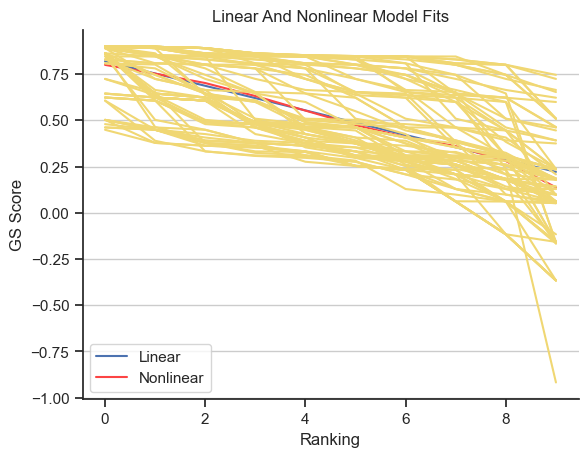

In [12]:
# creating X and Y data to fit models
similar_gs_scores = []
for i in communities_used:
    similar_gs_scores.append([j for j in gs_dist(i)["gs_score"]])
similar_gs_scores = pd.DataFrame(similar_gs_scores)
similar_gs_points = []
for i in similar_gs_scores.columns:
    for j in similar_gs_scores.loc[:, i]:
        similar_gs_points.append([i, j])
similar_gs_points = pd.DataFrame(similar_gs_points)

# fitting and plotting
lr = LinearRegression()
nlr = SVR()
lr.fit(similar_gs_points[[0]], similar_gs_points[1])
nlr.fit(similar_gs_points[[0]], similar_gs_points[1])
fig, ax = plt.subplots()
ax.plot(pd.DataFrame(lr.predict(pd.DataFrame([i for i in range(10)]))), label="Linear")
ax.plot(pd.DataFrame(nlr.predict(pd.DataFrame([i for i in range(10)]))), label="Nonlinear", color="#fc4444")
for i in communities_used:
    ax.plot(gs_dist(i)["gs_score"], color="#f0d773")
ax.set_title("Linear And Nonlinear Model Fits")
ax.set_xlabel("Ranking")
ax.set_ylabel("GS Score")
ax.legend()
ax.yaxis.grid(True)

The nonlinear model appears to be fairly linear and both of the models appear to do a fairly good job representing the average line. This provides more assurance that the general trend is linear.

### Determining thresholds

Since the trend is generally linear regardless of the topic, it would be a good idea to try returning the top 3 most similar communities as beginner communities and the bottom 3 of the top 10 most similar communities as advanced communities.

We can try validating the effectiveness of the thresholds by checking the differences between the average GS scores of the recommended beginner communities and the average GS scores of the recommended advanced communities.

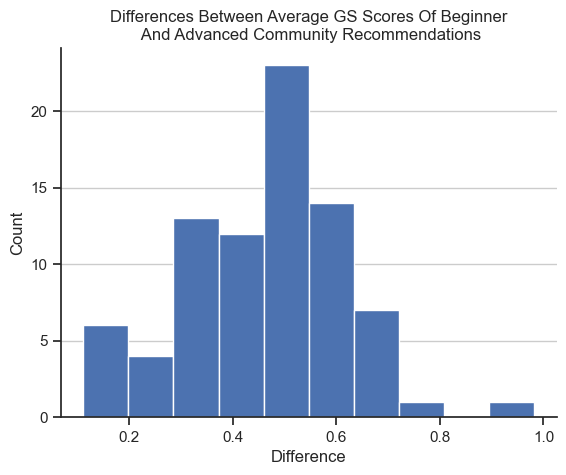

In [13]:
differences = pd.DataFrame([np.mean(gs_dist(i)["gs_score"][0:3]) - np.mean(gs_dist(i)["gs_score"][7:10]) for i in communities_used])
ax = differences.plot.hist()
ax.set_title("Differences Between Average GS Scores Of Beginner\n And Advanced Community Recommendations")
ax.set_xlabel("Difference")
ax.set_ylabel("Count")
ax.get_legend().remove()
ax.yaxis.grid(True)

The differences are mainly around 0.5, which means that the thresholds appear to do a good job of separating the communities by their GS scores on average.

We now try the community recommendation function with the news subreddit.

In [14]:
def recommend(x):
    similar = gs_dist(x)
    print("Beginner Communities:")
    print(similar[0:3])
    print()
    print("Advanced Communities:")
    print(similar[7:10].reset_index(drop=True))

recommend("news")

Beginner Communities:
        subreddit  gs_score
0  DestinyTheGame  0.479266
1          videos  0.448635
2          canada  0.391248

Advanced Communities:
       subreddit  gs_score
0  SquaredCircle  0.252884
1   pcmasterrace  0.232065
2     classicwow -0.166163


The beginner communities appear to be general, while the advanced communities appear to be more specific, so the recommendations seem reasonable.